## Workbook 2 - Training a Feed-Forward Neural Network using UrbanSound8K audio data 

This loads the features we extracted using librosa (see workbook 1), and uses them to train a Feed-Forward Network, a simple deep neural net with a few hidden layers, and then predict the class of a set of previously unheard audio files. You will need librosa, keras and tensorflow installed to run this code, and the latest version of scikit-learn (currently 0.18.1).

In [2]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

This code below loads previously computed numpy features for each of the 10 folds, we'll use the first 8 for training, and keep one back for validation and one for testing.

In [3]:
data_dir = "data/us8k-np-ffn"

def add_folds():
    subsequent_fold = False
    for k in range(1,9):
        fold_name = 'fold' + str(k)
        print "\nAdding " + fold_name
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print "New Features: ", loaded_features.shape

        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels

train_x, train_y = add_folds()

# use a fold for validation
valid_fold_name = 'fold9'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
valid_x = np.load(feature_file)
valid_y = np.load(labels_file) 

# and a fold for testing
test_fold_name = 'fold10'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)

print "\nTraining Set Features:", train_x.shape, "Labels:", train_y.shape
print "Validation Set Features:", valid_x.shape, "Labels:", valid_y.shape
print "Test Set Features:", test_x.shape, "Labels:", test_y.shape



Adding fold1
New Features:  (873, 193)

Adding fold2
New Features:  (888, 193)

Adding fold3
New Features:  (925, 193)

Adding fold4
New Features:  (990, 193)

Adding fold5
New Features:  (936, 193)

Adding fold6
New Features:  (823, 193)

Adding fold7
New Features:  (838, 193)

Adding fold8
New Features:  (806, 193)

Training Set Features: (7079, 193) Labels: (7079, 10)
Validation Set Features: (816, 193) Labels: (816, 10)
Test Set Features: (837, 193) Labels: (837, 10)


### Training Neural Network with Keras and TensorFlow

In [4]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [5]:
def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

# neural network dimensions
n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = 400 # approx n_dim * 2
n_hidden_units_3 = 200 # half of layer 2

checkpoint_dir = "model"
assure_path_exists(checkpoint_dir)

print "Features:", n_dim, "Classes:", n_classes

Features: 193 Classes: 10


The following cell contains the code to create and train a feed-forward neural network with 3 hidden layers.

In successive training epochs, notice how the training set loss decreases, whilst the accuracy increases - this shows the model is learning. But we don't want the model to simply memorise the training data and not have the capability to generalise to examples it hasn't seen before. So a stopping function is used to evaluate a separate measure of loss against an unseen validation set, which allows training to be halted at the point when the model begins to lose its ability to generalise.

The neural network implemented below has 3 hidden (densely connected) layers, plus an output layer. In between layers 2 and 3, and 3 and 4, a Dropout policy of 0.5 has been added. This means there's a 50% that a neuron's activation output will be ignored, and not propagated to its downstream connections, and it will not have its weights updated on the backward pass.

This random throwing away of information helps prevent the network from learning simple spurious dependencies, and promotes the creation of complex co-adaptations between neurons of the hidden layers. The idea is to encourage other neurons to become involved, if they learn on behalf of the missing neurons, it will result in the creation of multiple independent internal representations by different groupings of neurons across the network. 

Another parameter that affects performance is the batch size: the number of feature rows to be shown to the network before the backpropagation process updates the weights of the network. 


In [30]:
tf.set_random_seed(0)
np.random.seed(0)

def create_model(activation_function='relu', init_type='normal', optimiser='Adamax', dropout_rate=0.5):
    model = Sequential()
    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, init=init_type, activation=activation_function))
    # layer 2
    model.add(Dense(n_hidden_units_2, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, init=init_type, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

model = create_model()

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], nb_epoch=30, batch_size=24)


/Users/leonmak/.virtualenvs/keras-tf2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, activation="relu", kernel_initializer="normal", input_dim=193)`
  import sys
/Users/leonmak/.virtualenvs/keras-tf2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
/Users/leonmak/.virtualenvs/keras-tf2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
/Users/leonmak/.virtualenvs/keras-tf2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`
  from ipykernel import kernelapp as app


Train on 7079 samples, validate on 816 samples
Epoch 1/30
7079/7079 [==============================] - 4s 499us/step - loss: 2.2452 - acc: 0.3125 - val_loss: 1.5132 - val_acc: 0.4400
Epoch 2/30
7079/7079 [==============================] - 2s 242us/step - loss: 1.5823 - acc: 0.4756 - val_loss: 1.4340 - val_acc: 0.4853
Epoch 3/30
7079/7079 [==============================] - 2s 213us/step - loss: 1.3433 - acc: 0.5540 - val_loss: 1.3642 - val_acc: 0.5184
Epoch 4/30
7079/7079 [==============================] - 2s 215us/step - loss: 1.1761 - acc: 0.6204 - val_loss: 1.3520 - val_acc: 0.5466
Epoch 5/30
7079/7079 [==============================] - 2s 235us/step - loss: 1.0437 - acc: 0.6632 - val_loss: 1.3754 - val_acc: 0.5772
Epoch 6/30
7079/7079 [==============================] - 2s 233us/step - loss: 0.9280 - acc: 0.7014 - val_loss: 1.4491 - val_acc: 0.5674
Epoch 7/30
7079/7079 [==============================] - 2s 220us/step - loss: 0.8636 - acc: 0.7257 - val_loss: 1.4719 - val_acc: 0.5772
E

### Measuring Accuracy

In [15]:
from sklearn import metrics 
from keras.utils import np_utils

# obtain the prediction probabilities
y_prob = model.predict_proba(test_x, verbose=0)
y_pred = model.predict_classes(test_x)
y_true = np.argmax(test_y, 1)

roc = metrics.roc_auc_score(test_y, y_prob)
print "ROC:",  round(roc,2)

# evaluate the model
score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
print("\nAccuracy = {:.2f}".format(accuracy))

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,2)

837/837 [==============================] - 0s 85us/step
ROC: 0.88
837/837 [==============================] - 0s 94us/step

Accuracy = 0.54
F-Score: 0.54


ROC curves are typically used in binary classification, so to apply this measure to multi-class classification, it's first necessary to convert the predictions into boolean values, each representing positive or negative predictions for each possible class. This enables us to draw one ROC curve per class, or draw a composite ROC curve by using micro-averaging.

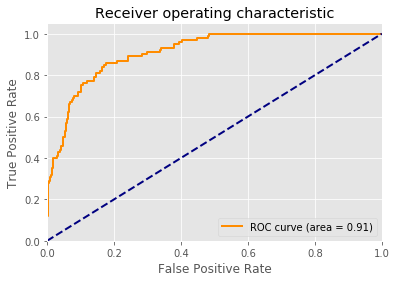

In [16]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Showing Misclassification with a Confusion Matrix

We can visualise the accuracy using a confusion matrix, which shows which categories tend to be correctly classified, and which classes are misclassified. Compare, for example, the consistent classification of air conditioning, with the more equivocal results for children playing.

Confusion_matrix
           aircon   horn  child    dog  drill engine    gun hammer  siren  music
    aircon     56      0      5      0      0      2      0     34      1      2
      horn      3     22      0      0      3      0      0      1      0      4
     child      1      1     67     14      0      2      0      0     10      5
       dog      3      0     16     58      3      3      0      3      6      8
     drill      0      1      8      0     38      7      0     13      9     24
    engine     11      0     30      1      0     50      0      1      0      0
       gun      0      0      0     20      0      0      9      0      3      0
    hammer      1      0      6      0     29      0      0     59      0      1
     siren     13      0     19      8      0      0      0      0     43      0
     music     12      2     15      1      9      2      0      4      4     51


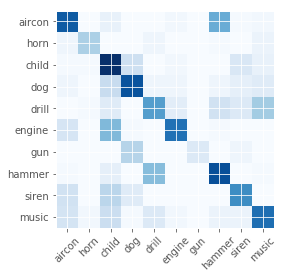

In [23]:
from sklearn.metrics import confusion_matrix

labels = ["aircon","horn","child","dog","drill","engine","gun","hammer","siren","music"]
print "Confusion_matrix"
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print "    " + empty_cell,
    for label in labels: 
        print "%{0}s".format(columnwidth) % label,
    print
    # Print rows
    for i, label1 in enumerate(labels):
        print "    %{0}s".format(columnwidth) % label1,
        for j in range(len(labels)): 
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print cell,
        print
    
print_cm(cm, labels)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)


### Refinement and Optimisation

The performance of a deep neural network is highly dependent on many configurable hyper-parameters, values that govern how the model actually works, and which are not changed during the course of learning. Some of these parameters will have a greater influence than others. The classic machine learning solution to this challenge is GridSearch, to successively train separate instances of a model with distinct values of key parameters, and then compare the resulting accuracy scores to identify which combination of parameters has produced the best results. 

Scikit-Learn provides GridSearch functionality that can be adapted for use with a neural network implemented using Keras, as described here: http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/. 

Because the training process is computationally intensive, and must be repeated for each combination of hyper-parameter values, optimisation can be a slow, time-consuming process. The code below shows how the 3-layer network was trained with different stochastic gradient optimisers (https://keras.io/optimizers/), and reveals which algorithms work best for this particular problem domain.

### Generating Predictions ###
Once we've trained a model, we can use the following process to pass an audio file into our model and generate predictions, which will be the activation value (between 0 and 1) at the output layer for each of the 10 possible classes. Collectively, all the activations will sum to 1, meaning we can use argmax to show what the network's best guess is, as a well as providing a measure of its confidence.

The following fragment considers 10 different audio samples, one for each class, showing the model's best guess (highest activation value), as well as the second best guess, which can provide useful insights in those cases where the model misidentifies the sample. After all, as you can see from the results, the predictions are not perfect. 

In [27]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm

# activations = ['relu', 'tanh', 'linear']
# batch_sizes = [10, 20, 30, 40, 50, 60]
# epochs = [10, 20, 30]
# dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

optimisers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

model = KerasClassifier(build_fn=create_model, nb_epoch=5, batch_size=24, verbose=0)

# define the grid search parameters
# just using one here for illustration, but add activation_function=activations 
# or dropout_rate=dropout_rates to grid search on other parameters
param_grid = dict(optimiser=optimisers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

print "Running GridSearch..."
grid_result = grid.fit(train_x, train_y)
print "GridSearch complete"

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Running GridSearch...


/Users/leonmak/.virtualenvs/keras-tf2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, activation="relu", kernel_initializer="normal", input_dim=193)`
  import sys
/Users/leonmak/.virtualenvs/keras-tf2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
/Users/leonmak/.virtualenvs/keras-tf2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
/Users/leonmak/.virtualenvs/keras-tf2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`
  from ipykernel import kernelapp as app


GridSearch complete
Best: 0.513349 using {'optimiser': 'Adagrad'}
0.439610 (0.008523) with: {'optimiser': 'SGD'}
0.493290 (0.023073) with: {'optimiser': 'RMSprop'}
0.513349 (0.009258) with: {'optimiser': 'Adagrad'}
0.499788 (0.027595) with: {'optimiser': 'Adadelta'}
0.503461 (0.018784) with: {'optimiser': 'Adam'}
0.507134 (0.025843) with: {'optimiser': 'Adamax'}
0.496539 (0.012927) with: {'optimiser': 'Nadam'}


In [ ]:
# Fit model again
model = create_model(optimiser=grid_result.best_params_['optimiser'])
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], nb_epoch=30, batch_size=24)

In [31]:
import librosa

sound_file_paths = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                    "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
parent_dir = 'samples/us8k/'


# just extract the features, 
def extract_features_only(filename):
    features = np.empty((0,193))
    X, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    return features

# create predictions for each of the sound classes
for s in range(len(sound_names)):

    print "\n----- ", sound_names[s], "-----"
    # load audio file and extract features
    predict_file = parent_dir + sound_file_paths[s]
    predict_x = extract_features_only(predict_file)
    
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    
    #for i in range(len(predictions[0])):
    #    print sound_names[i], "=", round(predictions[0,i] * 100, 1)
    
    # get the indices of the top 2 predictions, invert into descending order
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    
    print "Top guess: ", sound_names[ind[0]], " (",round(predictions[0,ind[0]],3),")"
    print "2nd guess: ", sound_names[ind[1]], " (",round(predictions[0,ind[1]],3),")"



-----  air conditioner -----
Top guess:  air conditioner  ( 0.531 )
2nd guess:  children playing  ( 0.106 )

-----  car horn -----
Top guess:  car horn  ( 0.989 )
2nd guess:  street music  ( 0.005 )

-----  children playing -----
Top guess:  children playing  ( 0.415 )
2nd guess:  street music  ( 0.178 )

-----  dog bark -----
Top guess:  dog bark  ( 0.944 )
2nd guess:  gun shot  ( 0.043 )

-----  drilling -----
Top guess:  drilling  ( 0.985 )
2nd guess:  jackhammer  ( 0.01 )

-----  engine idling -----
Top guess:  engine idling  ( 0.885 )
2nd guess:  jackhammer  ( 0.035 )

-----  gun shot -----
Top guess:  gun shot  ( 0.345 )
2nd guess:  dog bark  ( 0.206 )

-----  jackhammer -----
Top guess:  air conditioner  ( 0.592 )
2nd guess:  engine idling  ( 0.251 )

-----  siren -----
Top guess:  siren  ( 1.0 )
2nd guess:  dog bark  ( 0.0 )

-----  street music -----
Top guess:  street music  ( 0.993 )
2nd guess:  jackhammer  ( 0.003 )


As the feature extraction process relies on slicing the sound recordings into smaller, more manageable chunks, if we needed to predict the class of a longer recording, we might need to employ some kind of ensemble learning, where we establish a prediction for each slice of the recording, and then use a voting process to determine which source is declared the best guess. 

This voting approach could make use of the fact that the softmax activation function will return equivocal values if it has low confidence in its prediction. An example of that can be seen above in the gunshot example, where dogbark and gunshot have very similar probabilities. In such cases we could ignore weak predictions, ensuring only strong predictions contribute to the final voting decision. A system that uses this approach is described here: https://chatbotslife.com/finding-the-genre-of-a-song-with-deep-learning-da8f59a61194

### Evaluating Convergence

There is also valuable information about learning performance in the history object. This can, for instance, reveal the speed of convergence over epochs, initially a slope, which may ultimately plateau out.
Whether the mode may be over-learning the training data (inflection for validation line).

From the plot of accuracy indicates whether the model could be trained further (if the accuracy trend is still rising for the final epochs). It will also indicate if the model has over-learned the training dataset, it should show comparable performance on both train and test datasets.

If the model is overfitting the accuracy graph will show excellent performance on the training data, and poor performance on the test data.

Ideally, in the loss graph, we should see comparable performance in both the training and validation datasets. Should these parallel plots start to diverge, it might be a indication we should stop training earlier. For a more detailed explanation, see http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/


History keys: ['acc', 'loss', 'val_acc', 'val_loss']


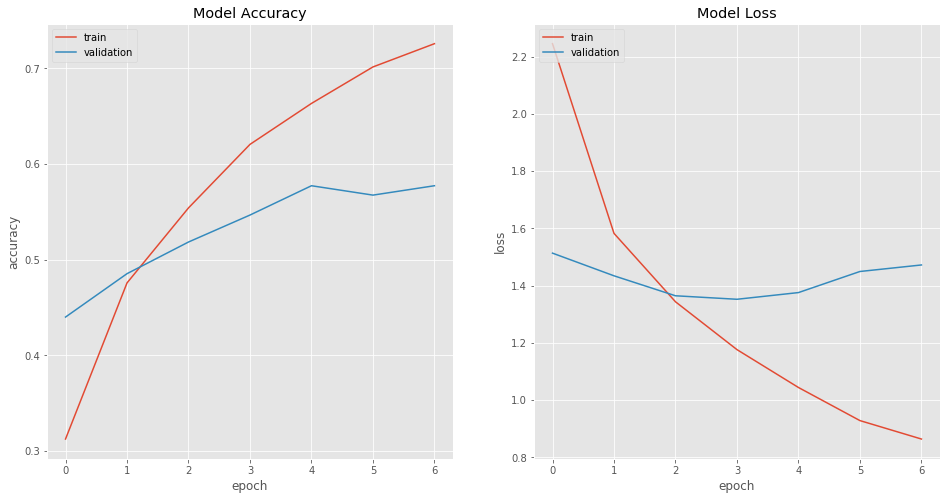

In [32]:
fig = plt.figure(figsize=(16,8))

print "History keys:", (history.history.keys())
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()